In [ ]:
#Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import nltk
nltk.download('stopwords') 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,auc,roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import zipfile
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip
zip_file = zipfile.ZipFile('glove.840B.300d.zip')
zip_file.extractall('./embeddings/')

--2020-06-20 22:11:17--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2020-06-20 22:11:18--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2020-06-20 22:11:18--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## This Notebook covers: 
- Preprocessing the data
- tfidf
- count vector features
- Modeling with Traditional ML Algorithms
  1. logistic regression
  2. naive bayes
  3. svm
  4. xgboost
- Building Model with RNN
  1. LSTM without Pretrained Embedding
  2. Bi-Directional LSTM with GloVe Embeddings
  3. GRU with GloVe Embeddings
- Conclusion
- Pickling files

In [ ]:
#Read the Data
df_news=pd.read_excel('/content/drive/My Drive/Colab Notebooks/Headline_TOI.xlsx')
df_news.tail()

,Headline,Censor
1263,Unforgettable: Yusuf who debuted in 2007 WT20 ...,0
1264,38 died while cleaning sewers in Delhi in last...,1
1265,"Food brand Ketofy raises $250,000 in pre-Serie...",0
1266,Low-lying areas in Bihar flooded as Ganga's wa...,1
1267,"Trump criticises China, says it has broken pro...",0


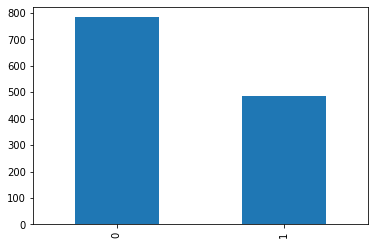

In [ ]:
#Plotting the labels
df_news['Censor'].value_counts().plot.bar()

## Preprocessing the Data

In [ ]:
#Removing Punctuations from the text
df_news.replace("[^a-zA-Z]"," ",regex=True, inplace=True)
df_news.head()

,Headline,Censor
0,Law against religious conversion,1
1,Woman sets baby ablaze,1
2,Submit project plans by Jan BMC,0
3,Nanded gets new revenue division tag,0
4,Several arts to beat together at NCPA,0


In [ ]:
#Lower case the whole text
data=df_news['Headline'].str.lower()
df_news['Headline']=data
df_news.head()

,Headline,Censor
0,law against religious conversion,1
1,woman sets baby ablaze,1
2,submit project plans by jan bmc,0
3,nanded gets new revenue division tag,0
4,several arts to beat together at ncpa,0


In [ ]:
# Removing the stop words
stop=stopwords.words('english')

df_news['Headline']=df_news['Headline'].apply(lambda x:" ".join(x for x in x.split() if x not in stop))

In [ ]:
#splitting the data
X_train, X_test, y_train, y_test = train_test_split(df_news['Headline'], df_news['Censor'], 
                                                    test_size = 0.2, random_state = 42)


Let's start building our very first model.

Our very first model is a simple TF-IDF (Term Frequency - Inverse Document Frequency) followed by a simple Logistic Regression.

## TF-IDF using word vectorizer

In [ ]:
#Transorming input text using TF-IDF (Term Frequency - Inverse Document Frequency)
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode',analyzer='word',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            #stop_words = 'english'
                     )

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(X_train) + list(X_test))
xtrain_tfv =  tfv.transform(X_train) 
xtest_tfv = tfv.transform(X_test)

## Count Vector

---



Instead of using TF-IDF, we can also use word counts as features. This can be done easily using CountVectorizer from scikit-learn.

In [ ]:
#Transorming input text using Count Vectorizer or Bag of words
ctv = CountVectorizer(analyzer='word',
            ngram_range=(1, 1)#, stop_words = 'english'
                     )

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(X_train) + list(X_test))
xtrain_ctv =  ctv.transform(X_train) 
xtest_ctv = ctv.transform(X_test)

## Building Models <br>

### Logistic Regression

---



In [ ]:
# Fitting a simple Logistic Regression on TFIDF
lr_tfv = LogisticRegression(C=1.0)
lr_tfv.fit(xtrain_tfv, y_train)
predictions = lr_tfv.predict(xtest_tfv)
score=accuracy_score(y_test,predictions)
print(score)
print(roc_auc_score(y_test, predictions))

0.7480314960629921
0.6779874213836478


In [ ]:
# Fitting a simple Logistic Regression on count vector
lr_ctv = LogisticRegression(C=1.0)
lr_ctv.fit(xtrain_ctv, y_train)
predictions = lr_ctv.predict(xtest_ctv)
score=accuracy_score(y_test,predictions)
print(score)
print(roc_auc_score(y_test, predictions))

0.7716535433070866
0.7201588877855015


### Naive Bayes

---




In [ ]:
# Fitting a simple Naive Bayes on TFIDF
nb_tfv = MultinomialNB()
nb_tfv.fit(xtrain_tfv, y_train)
predictions = nb_tfv.predict(xtest_tfv)
score=accuracy_score(y_test,predictions)
print(score)
print(roc_auc_score(y_test, predictions))

0.7598425196850394
0.7149619331347236


In [ ]:
# Fitting a simple Naive Bayes on Count vector
nb_ctv = MultinomialNB()
nb_ctv .fit(xtrain_ctv, y_train)
predictions = nb_ctv .predict(xtest_ctv)
score=accuracy_score(y_test,predictions)
print(score)
print(roc_auc_score(y_test, predictions))

0.7362204724409449
0.7321085733200927


### SVM

---



In [ ]:
# Fitting a simple SVM with tf-idf
svc_tfv = SVC(C=1, probability=True) # since we need probabilities
svc_tfv.fit(xtrain_tfv, y_train)
predictions = svc_tfv.predict(xtest_tfv)
score=accuracy_score(y_test,predictions)
print(score)

0.7401574803149606


In [ ]:
# Fitting a simple SVM with count vector
svc_ctv = SVC(C=1, probability=True) # since we need probabilities
svc_ctv.fit(xtrain_ctv, y_train)
predictions = svc_ctv.predict(xtest_ctv)
score=accuracy_score(y_test,predictions)
print(score)

0.7204724409448819


### XGB

In [ ]:
# Fitting a simple xgboost on tf-idf
xgb_tfv = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
xgb_tfv.fit(xtrain_tfv.tocsc(), y_train)
predictions = xgb_tfv.predict(xtest_tfv.tocsc())
score=accuracy_score(y_test,predictions)
print(score)
print(roc_auc_score(y_test, predictions))

0.7204724409448819
0.6517378351539226


In [ ]:
# Fitting a simple xgboost on CTV
xgb_ctv = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
xgb_ctv.fit(xtrain_ctv.tocsc(), y_train)
predictions = xgb_ctv.predict(xtest_ctv.tocsc())
score=accuracy_score(y_test,predictions)
print(score)
print(roc_auc_score(y_test, predictions))

0.7165354330708661
0.6443561734524992


# **Modelling with RNN**

In [ ]:
#Imporing Libraries for RNN based modelling
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.models import Model
from keras.models import load_model

from keras.layers import Input,Dense,Embedding,Conv1D,Conv2D,MaxPooling1D, MaxPooling2D,Activation
from keras.layers import Flatten,Dropout,Reshape,Concatenate,SpatialDropout1D,concatenate
from keras.layers import GlobalMaxPooling1D,GlobalAveragePooling1D,GRU,Bidirectional,LSTM

from keras.callbacks import Callback
from keras.callbacks import EarlyStopping,ModelCheckpoint

from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam



In [ ]:
#Tokenizing the text
max_nums=50000
tokenizer=Tokenizer(num_words=max_nums)
tokenizer.fit_on_texts(df_news['Headline'])

In [ ]:
#Example of converting text to a sequence
print(X_train[5])
tokenizer.texts_to_sequences([X_train[5]])

rane stalls plan quit congress


[[364, 1198, 82, 240, 1199]]

In [ ]:
#Converting the text into numbers as seen the example above
train_sequence=tokenizer.texts_to_sequences(X_train)
test_sequence=tokenizer.texts_to_sequences(X_test)

In [ ]:
#Padding all the rows of data to the same length i.e. 20
maxlen_pad=20
padded_train_sequence=pad_sequences(train_sequence,maxlen=maxlen_pad)
padded_test_sequence=pad_sequences(test_sequence,maxlen=maxlen_pad)

In [ ]:
padded_train_sequence

array([[   0,    0,    0, ..., 1265,  615, 1266],
       [   0,    0,    0, ..., 1501, 1502, 1503],
       [   0,    0,    0, ..., 2469, 1002, 1003],
       ...,
       [   0,    0,    0, ..., 1135,  271,   92],
       [   0,    0,    0, ..., 2658,  155,  239],
       [   0,    0,    0, ..., 1123,  108,    7]], dtype=int32)

In [ ]:
padded_train_sequence.shape

(1014, 20)


## A simple LSTM without Pretrained Embedding

In [ ]:
embedding_dim=300
embedding_random=np.random.random((max_nums,embedding_dim))
random_model = Sequential()
random_model.add(Embedding(input_dim=max_nums, output_dim=embedding_dim, input_length=maxlen_pad, 
                  weights=[embedding_random], trainable=True))
random_model.add(SpatialDropout1D(0.3))
random_model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3))

random_model.add(Dense(1024, activation='relu'))
random_model.add(Dropout(0.8))

random_model.add(Dense(1024, activation='relu'))
random_model.add(Dropout(0.8))

random_model.add(Dense(1))
random_model.add(Activation('sigmoid'))
random_model.compile(loss='binary_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

random_model.fit(x=padded_train_sequence, 
                    y=y_train, 
                    validation_data=(padded_test_sequence, y_test),  
                    batch_size=32, 
                    epochs=20, 
                    verbose=1,callbacks=[earlystop])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1014 samples, validate on 254 samples
Epoch 1/20
1014/1014 [==============================] - 12s 12ms/step - loss: 0.7599 - val_loss: 0.6824
Epoch 2/20
1014/1014 [==============================] - 11s 11ms/step - loss: 0.7258 - val_loss: 0.6833
Epoch 3/20
1014/1014 [==============================] - 12s 11ms/step - loss: 0.6951 - val_loss: 0.6622
Epoch 4/20
1014/1014 [==============================] - 11s 11ms/step - loss: 0.6808 - val_loss: 0.6635
Epoch 5/20
1014/1014 [==============================] - 11s 11ms/step - loss: 0.6896 - val_loss: 0.6654
Epoch 6/20
1014/1014 [==============================] - 11s 11ms/step - loss: 0.6728 - val_loss: 0.6608
Epoch 7/20
1014/1014 [==============================] - 11s 11ms/step - loss: 0.6756 - val_loss: 0.6606
Epoch 8/20
1014/1014 [==============================] - 11s 11ms/step - loss: 0.6681 - val_loss: 0.6589
Epoch 9/20
1014/1014 [==============================] - 12s 12ms/step - loss: 0.6698 - val_loss: 0.6640
Epoch 10/20
1014/

In [ ]:
#Predicting 
y_pred_random=random_model.predict(padded_test_sequence)
y_pred_random=pd.DataFrame(y_pred_random,columns=['Prediction'])
y_pred_random['Prediction'] =y_pred_random['Prediction'].map(lambda x:1 if x>=0.5 else 0)

In [ ]:
print(accuracy_score(y_test, y_pred_random))
print(roc_auc_score(y_test, y_pred_random))

0.6771653543307087
0.5768950678583251


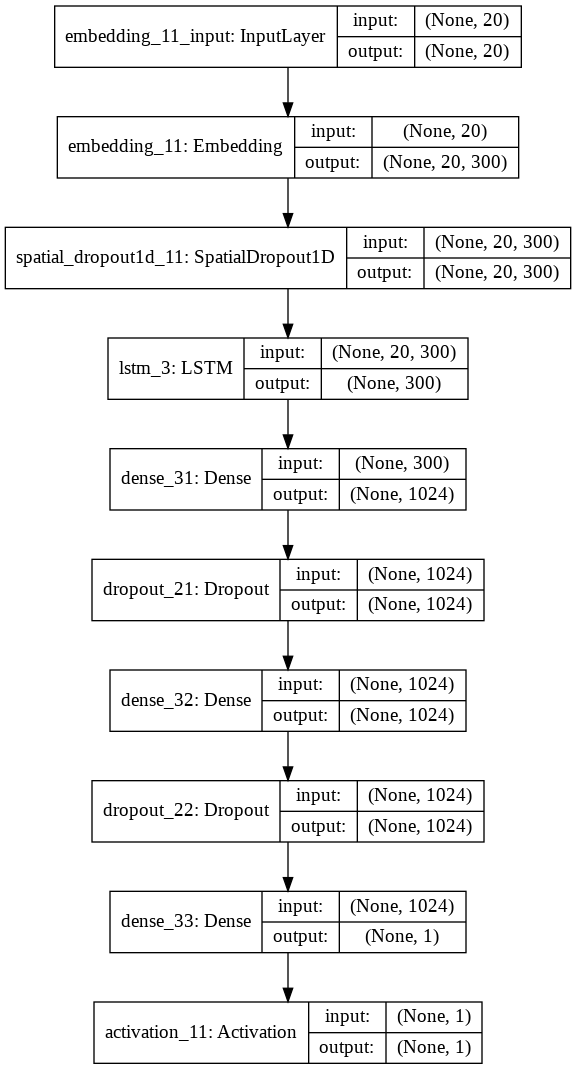

In [ ]:
plot_model(random_model, 
           #to_file='./images/rnn_simple_model.png', 
           show_shapes=True, 
           show_layer_names=True)

# Recurrent Neural Network with GloVe pre-trained embeddings

---



Going forward we will use the GloVe based embeddings to try various RNN layers.We will generate an embedding matrix from the GloVe text file. GloVe text file contains raw data where each line has a token and its corresponding embedding value in 300 dimension space!

In [ ]:
embeddings_index = {}
f = open('./embeddings/glove.840B.300d.txt')
for line in f:
  values = line.split()
  word = values[0]
  try:
    coefs = np.asarray(values[1:], dtype='float32')
  except:
    coefs=None
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 2195884 word vectors.


In [ ]:
word_index=tokenizer.word_index
print(len(word_index))

3448


In [ ]:
embedding_dim=300
embedding_matrix = np.zeros((max_nums,embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## A Bi-Directional LSTM with glove embeddings and two dense layers

In [ ]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=max_nums, output_dim=embedding_dim, input_length=maxlen_pad, 
                  weights=[embedding_matrix], trainable=True))
lstm_model.add(SpatialDropout1D(0.3))
lstm_model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

lstm_model.add(Dense(1024, activation='relu'))
lstm_model.add(Dropout(0.8))

lstm_model.add(Dense(1024, activation='relu'))
lstm_model.add(Dropout(0.8))

lstm_model.add(Dense(1))
lstm_model.add(Activation('sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

lstm_model.fit(x=padded_train_sequence, 
                    y=y_train, 
                    validation_data=(padded_test_sequence, y_test),  
                    batch_size=32, 
                    epochs=20, 
                    verbose=1,callbacks=[earlystop])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1014 samples, validate on 254 samples
Epoch 1/20
1014/1014 [==============================] - 18s 18ms/step - loss: 0.6319 - val_loss: 0.4382
Epoch 2/20
1014/1014 [==============================] - 16s 16ms/step - loss: 0.4837 - val_loss: 0.3906
Epoch 3/20
1014/1014 [==============================] - 17s 16ms/step - loss: 0.3851 - val_loss: 0.4374
Epoch 4/20
1014/1014 [==============================] - 16s 16ms/step - loss: 0.3289 - val_loss: 0.4202
Epoch 5/20
1014/1014 [==============================] - 16s 16ms/step - loss: 0.2036 - val_loss: 0.4941


In [ ]:
y_pred_rnn_lstm=lstm_model.predict(padded_test_sequence)
y_pred_rnn_lstm=pd.DataFrame(y_pred_rnn_lstm,columns=['Prediction'])
y_pred_rnn_lstm['Prediction'] =y_pred_rnn_lstm['Prediction'].map(lambda x:1 if x>=0.5 else 0)

In [ ]:
print(accuracy_score(y_test, y_pred_rnn_lstm))
print(roc_auc_score(y_test, y_pred_rnn_lstm))

0.8188976377952756
0.8002648129758358


## GRU with glove embeddings and two dense layers

In [ ]:
# 2 layer GRU
GRU_model = Sequential()
GRU_model.add(Embedding(input_dim=max_nums, output_dim=embedding_dim, input_length=maxlen_pad, 
                  weights=[embedding_matrix], trainable=True))
GRU_model.add(SpatialDropout1D(0.3))
GRU_model.add(GRU(100, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
GRU_model.add(GRU(100, dropout=0.3, recurrent_dropout=0.3))

GRU_model.add(Dense(512, activation='relu'))
GRU_model.add(Dropout(0.8))

GRU_model.add(Dense(512, activation='relu'))
GRU_model.add(Dropout(0.8))

GRU_model.add(Dense(1))
GRU_model.add(Activation('sigmoid'))
GRU_model.compile(loss='binary_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
GRU_model.fit(x=padded_train_sequence, 
                    y=y_train, 
                    validation_data=(padded_test_sequence, y_test),  
                    batch_size=32, 
                    epochs=20, 
                    verbose=1,callbacks=[earlystop])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1014 samples, validate on 254 samples
Epoch 1/20
1014/1014 [==============================] - 10s 10ms/step - loss: 0.6961 - val_loss: 0.6351
Epoch 2/20
1014/1014 [==============================] - 9s 9ms/step - loss: 0.6485 - val_loss: 0.5417
Epoch 3/20
1014/1014 [==============================] - 9s 9ms/step - loss: 0.5153 - val_loss: 0.4367
Epoch 4/20
1014/1014 [==============================] - 9s 9ms/step - loss: 0.4335 - val_loss: 0.4168
Epoch 5/20
1014/1014 [==============================] - 9s 8ms/step - loss: 0.4040 - val_loss: 0.4252
Epoch 6/20
1014/1014 [==============================] - 9s 9ms/step - loss: 0.3284 - val_loss: 0.4097
Epoch 7/20
1014/1014 [==============================] - 9s 9ms/step - loss: 0.2747 - val_loss: 0.4331
Epoch 8/20
1014/1014 [==============================] - 9s 9ms/step - loss: 0.2281 - val_loss: 0.4246
Epoch 9/20
1014/1014 [==============================] - 9s 9ms/step - loss: 0.1795 - val_loss: 0.4880


In [ ]:
y_pred_rnn_GRU=GRU_model.predict(padded_test_sequence)
y_pred_rnn_GRU=pd.DataFrame(y_pred_rnn_GRU,columns=['Prediction'])
y_pred_rnn_GRU['Prediction'] =y_pred_rnn_GRU['Prediction'].map(lambda x:1 if x>=0.5 else 0)

In [ ]:
#300
print(accuracy_score(y_test, y_pred_rnn_GRU))
print(roc_auc_score(y_test, y_pred_rnn_GRU))

0.8346456692913385
0.8340284673949024


#Conclusion

The recurrent Neural Network based model involving the GloVe embedding fares far better in performance.
<br>With the traditional ML algorithms Logistic Regression gives the best accuracy score of 77% with 0.72 ROC_AUC score.
<br> With RNN using pretrained GloVe Embedding using GRU based model gave 83% accuracy with .83 Roc_Auc score

# Pickling
Pickling files to be used while deploying using API

In [ ]:
#we shortlist Linear regression model based on count vectoriser for further implementation
LRML = open("censor_predict.pkl","wb")
pickle.dump(lr_ctv,LRML)
LRML.close()

In [ ]:
HT = open("headline_transform.pkl","wb")
pickle.dump(ctv,HT)
HT.close()